#Modelagem de risco de crédito - BayerBank

  <img src='https://raw.githubusercontent.com/lucasabo/Portfolio/main/bayer%20bank%20cut_auto_x2.jpg' width=550px>

Autor: Lucas Alexandre Santos | [LinkedIn](https://www.linkedin.com/in/lucasabo)

Dataset: German Credit Risk (Kaggle) | [Fonte](https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk)

#1 Entendimento do negócio

##1.1 Contexto


A análise de risco de crédito é um problema comum em instituições financeiras. Quando um banco concede crédito aos clientes, ele assume um risco de que eles não quitem o valor devido. Portanto, realizar previamente esse tipo de análise é fundamental para que a empresa evite prejuízos. 


BayerBank é uma fintech alemã que fornece serviços financeiros aos torcedores do FC Bayern Munich, maior clube do país. A empresa está em estágio inicial e ainda não estruturou um time de dados. Nesse sentido, você foi acionado para uma consultoria visando solucionar um problema atual da BayerBank: a alta taxa de inadiplência no serviço de empréstimos.

A empresa forneceu acesso a uma base histórica contendo dados socioeconômicos dos clientes, informações sobre a natureza do empréstimo e se o cliente pagou o empréstimo, totalizando 1000 registros e 10 variáveis 



## 1.2 Objetivo de negócio

Reduzir a taxa de inadiplência do serviço de empréstimos em um banco alemão.


##1.3 Objetivo de mineração de dados

Construir um modelo de classificação que preveja o risco de crédito com base em informaçoes socioeconômicas e do tipo de empréstimo solicitado.

##1.4 Critério de sucesso


Acurácia e ROC-AUC superiores a 0.7.



# 2  Entendimento dos dados

##2.1 Importando as bibliotecas

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [226]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

##2.2 Importando o dataset

In [227]:
df = pd.read_csv('/content/german_credit_data.csv', index_col=0)
df.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


##2.3 EDA

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


Apenas as colunas 'Saving accounts' e 'Checking account' possuem valores nulos.

Aparentemente a única conversão de formato será na coluna 'Risk'. Irei aplicar uma máscara e transformar em uma variável binária.

Para as outras variáveis a ideia inicial é: escalonar as variáveis numéricas e 'dummyficar' as variáveis categóricas.

###Descrição incial dos dados numéricos

In [229]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


Aparentemente não existem dados inconsistentes, isto é, valores negativos ou muito distantes da média. 

Mas iremos analisar em maiores detalhes.

### Análise gráfica dos dados numéricos

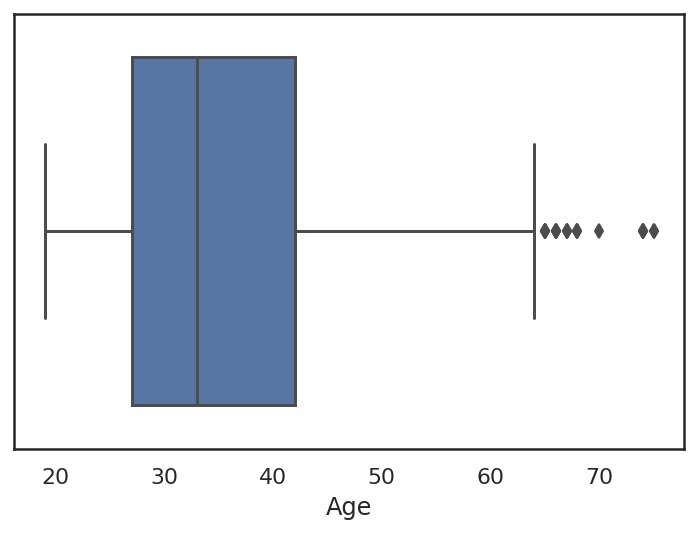

In [230]:
sns.set_theme(style="white")
age_box = sns.boxplot(x=df['Age'])

In [231]:
#df.loc[df['Age'] > 60, ['Age']] = 61


In [232]:
# #Box-cox
# from sklearn.preprocessing import PowerTransformer

# data_age = df['Age'].values.reshape(-1,1)

# boxcox_age = PowerTransformer(method='box-cox', standardize=False).fit_transform(data_age)

# df['Age'] = boxcox_age


In [233]:
#age_out = df.loc[df.Age >=60].index
#df = df.drop(index=age_out)

Observei possíveis outliers em todas as variáveis. 

Porém, aparentemente tratam-se de registros adequados e que fazem parte da população.

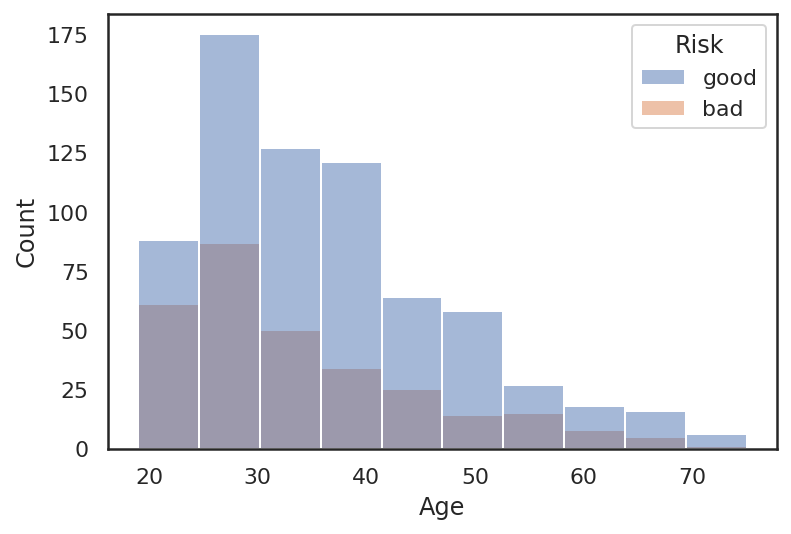

In [234]:
age_hist = sns.histplot(data=df, x='Age', hue='Risk', bins=10)

Observa-se o maior volume de empréstimos entre 25 e 40 anos.

Nota-se que o risco de crédito por idade é mais elevado entre 18 e 24 anos e por volta dos 55 anos.

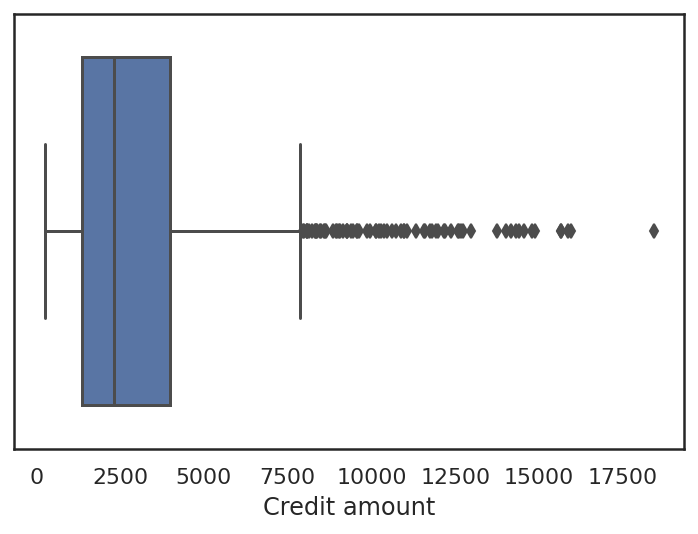

In [235]:
credit_box = sns.boxplot(x=df['Credit amount'])

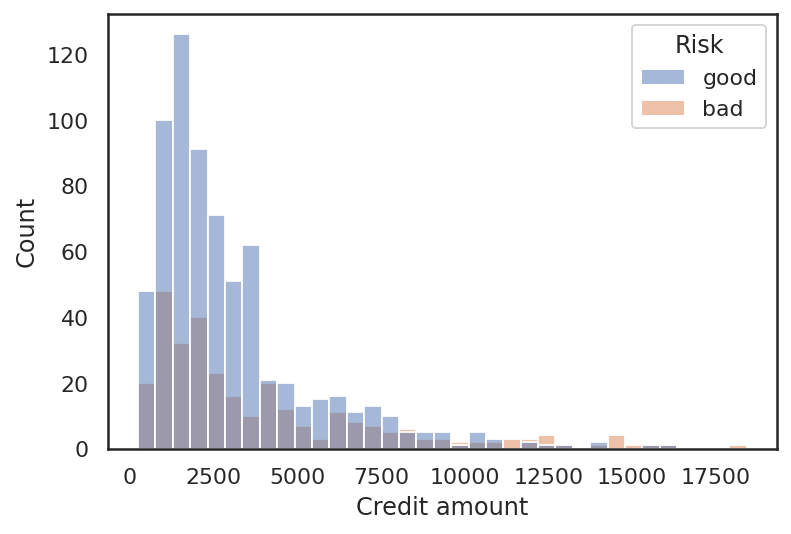

In [236]:
age_hist = sns.histplot(data=df, x='Credit amount', hue='Risk')

Empréstimos na faixa de até $3.200  tem um volume 5 vezes superior aos da segunda faixa.

Observa-se que o risco aumenta proporcionalmente ao valor do empréstimo.

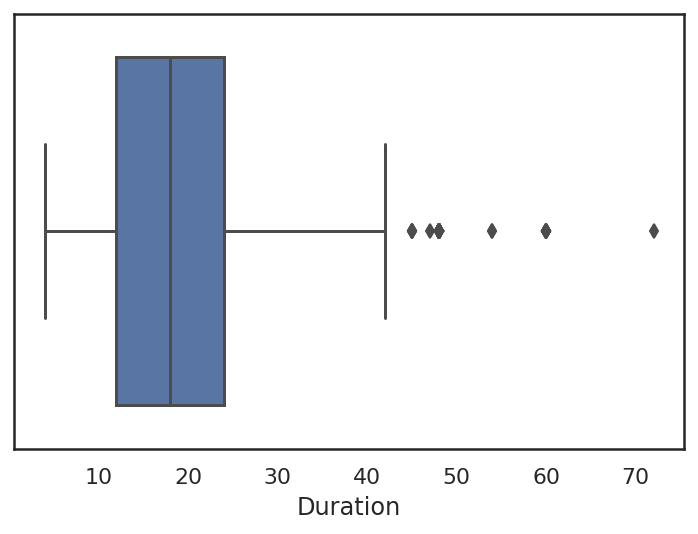

In [237]:
duration_box = sns.boxplot(x=df['Duration'])

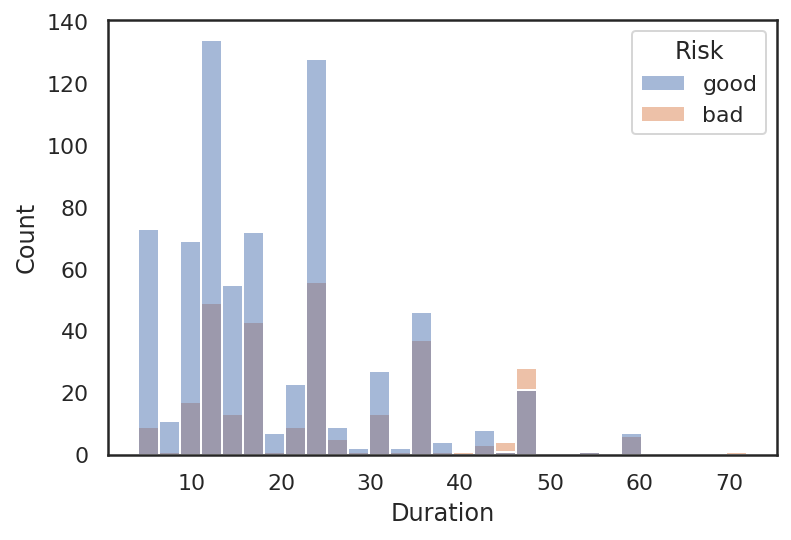

In [238]:
duration_hist = sns.histplot(data=df, x='Duration', hue='Risk')

A maioria dos empréstimos tem o prazo de 6, 12 e 24 meses.

O padrão da relação entre a duração do empréstimo e o risco não é intuitivo.

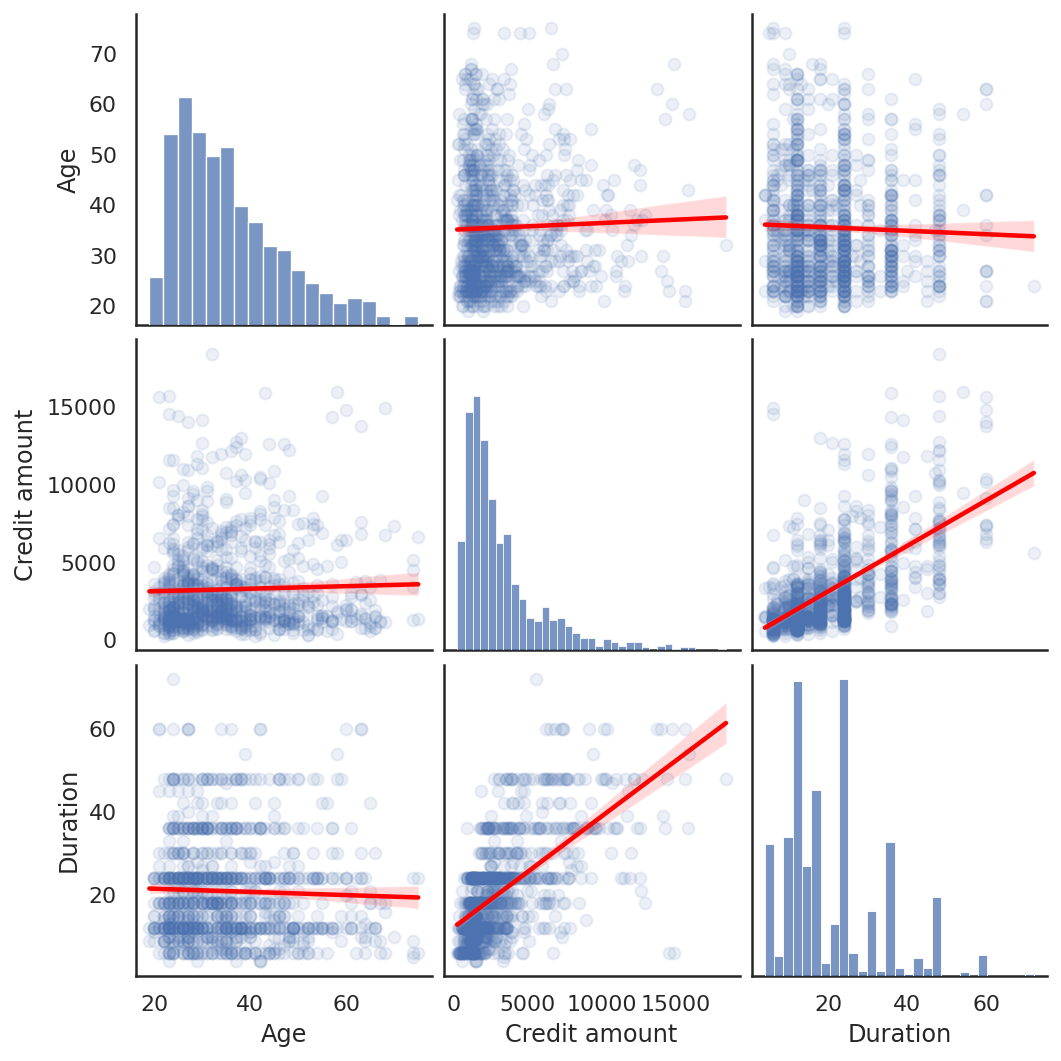

In [239]:
p = sns.pairplot(df.drop(columns=['Job']),kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

### Análise gráfica das variáveis categóricas

In [240]:
df_cat = df.select_dtypes('object')
df_cat.head(3)

,Sex,Housing,Saving accounts,Checking account,Purpose,Risk
0,male,own,NaN,little,radio/TV,good
1,female,own,little,moderate,radio/TV,bad
2,male,own,little,NaN,education,good


In [241]:
df_cat.isnull().sum()

Sex                   0
Housing               0
Saving accounts     183
Checking account    394
Purpose               0
Risk                  0
dtype: int64

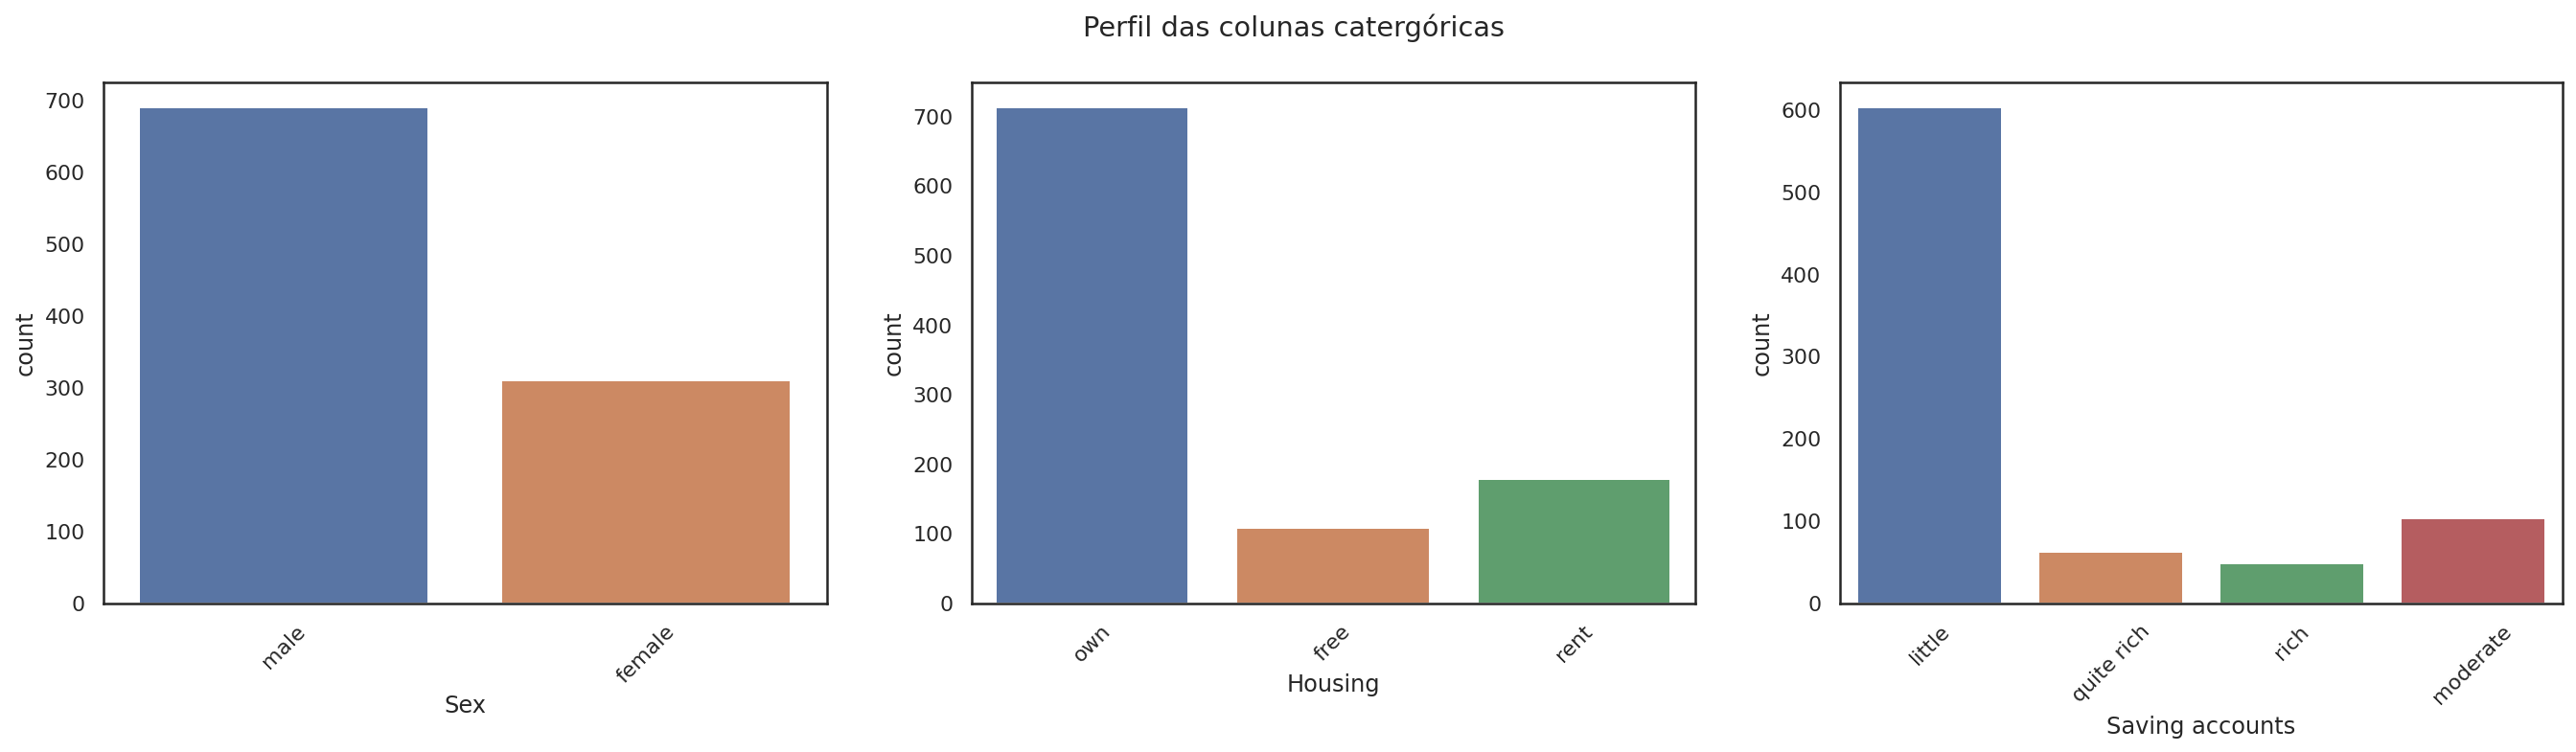

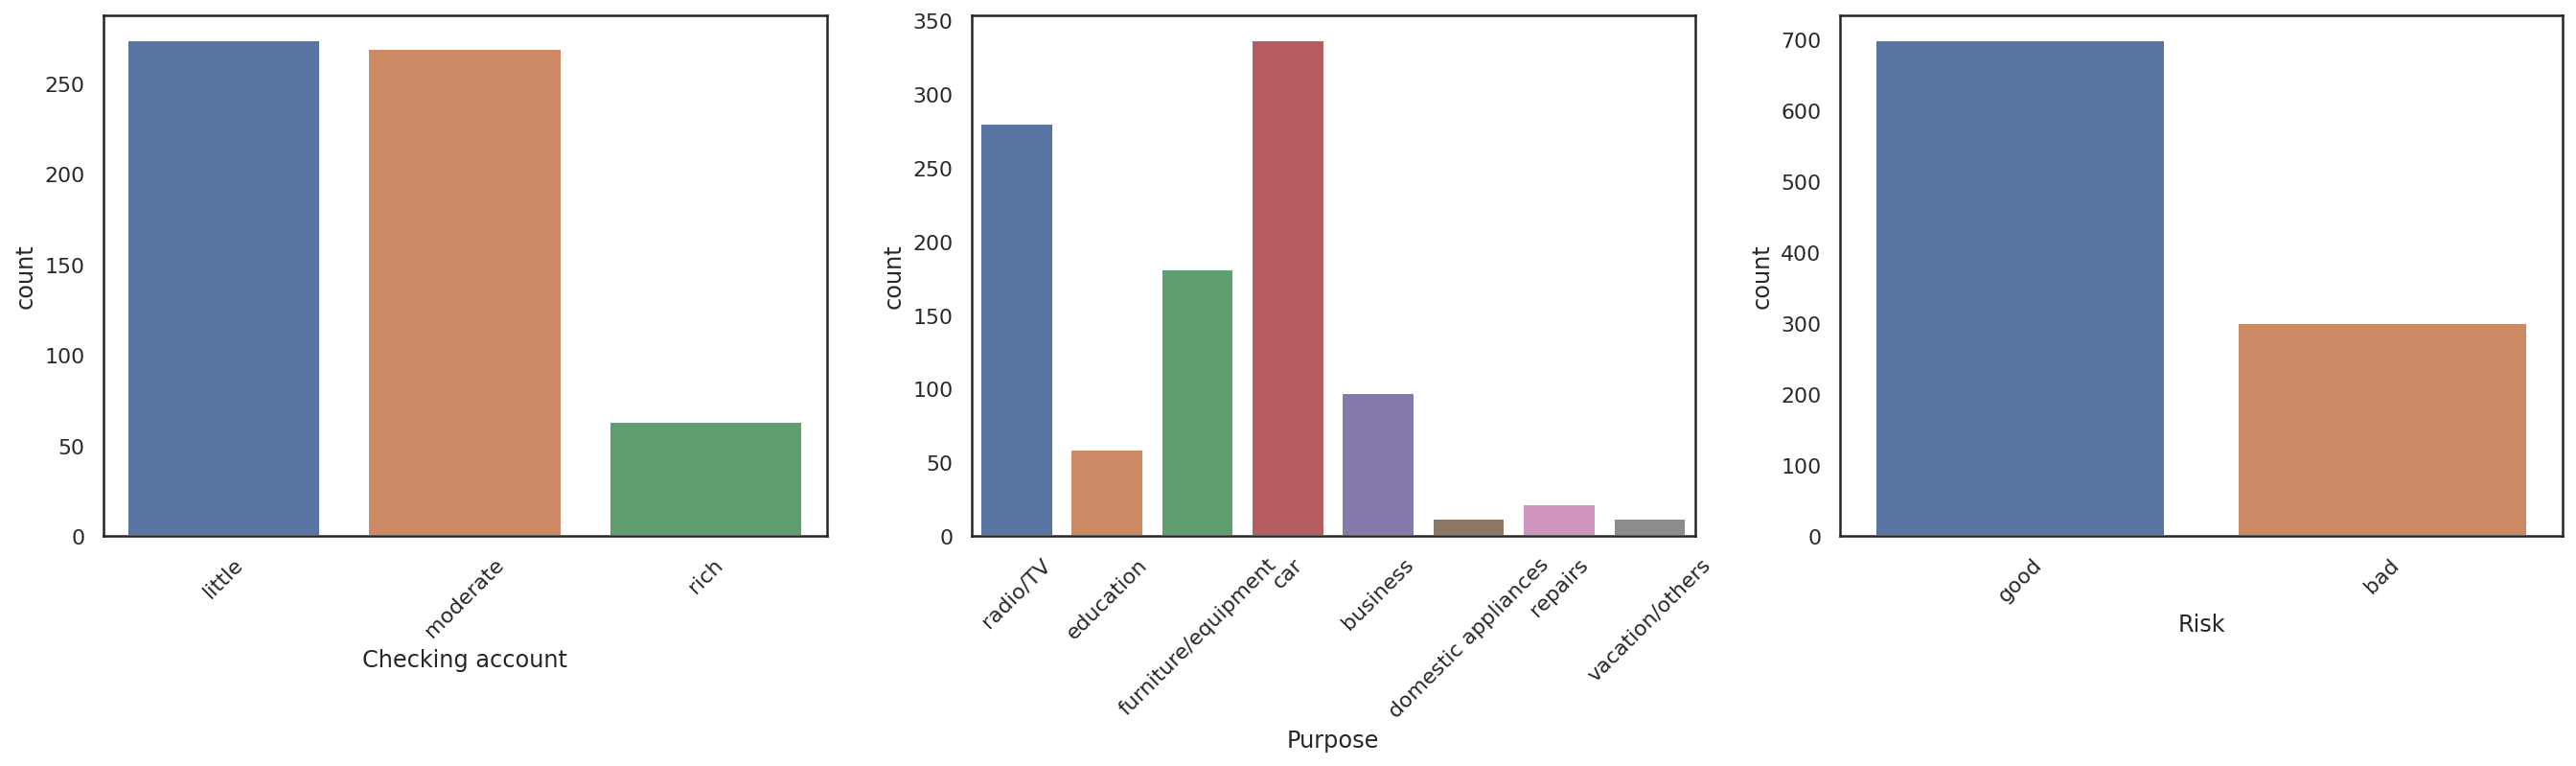

In [242]:
fig, axes = plt.subplots(1, 3, figsize=(23, 5))
fig2, axes2 = plt.subplots(1, 3, figsize=(23, 5))
fig.suptitle('Perfil das colunas catergóricas')

c_col = df_cat.dropna(subset=['Saving accounts'])['Saving accounts'].unique()
d_col = df_cat.dropna(subset=['Checking account'])['Checking account'].unique()

a = sns.countplot(ax=axes[0], data=df_cat, x='Sex').set_xticklabels(df_cat['Sex'].unique(), rotation=45)
b = sns.countplot(ax=axes[1], data=df_cat, x='Housing').set_xticklabels(df_cat['Housing'].unique(), rotation=45)
c = sns.countplot(ax=axes[2], data=df_cat, x='Saving accounts').set_xticklabels(c_col, rotation=45)

d = sns.countplot(ax=axes2[0], data=df_cat, x='Checking account').set_xticklabels(d_col, rotation=45)
e = sns.countplot(ax=axes2[1], data=df_cat, x='Purpose').set_xticklabels(df_cat['Purpose'].unique(), rotation=45)
f = sns.countplot(ax=axes2[2], data=df_cat, x='Risk').set_xticklabels(df_cat['Risk'].unique(), rotation=45)
plt.show()

Podemos observar que a maioria das variáveis apresentam classes distribuídas desproporcionalmente.

Além disso, conforme observado previamente, existe a presença de nulos em duas variáveis: 'Saving accounts' e 'Checking account'.

#3 Preparação dos dados

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 118.2+ KB


##Tratamento do Target

In [244]:
dicio = {'good': 0, 'bad':1}
df['Risk'] = df['Risk'].map(dicio) 
df['Risk'].unique()

array([0, 1])

##Construct Data

###Novas features

In [245]:
df = df.rename(columns={'Saving accounts': 'Saving_accounts', 
                        'Credit amount': 'Credit_amount',
                        'Checking account': 'Checking_account'})

In [246]:
df.head()

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


In [247]:
#Feature enginering geral - transformação
t_purpose = df.groupby(['Purpose']).agg({'Risk': 'sum', 'Duration': 'mean', 'Credit_amount': 'mean'})

#t_purpose.columns = ['_'.join(col).strip() if col[1] != "" else col[0] for col in t_purpose.columns.values]
t_purpose

,Risk,Duration,Credit_amount
Purpose,,,
business,34,26.938144,4158.041237
car,106,20.813056,3768.192878
domestic appliances,4,16.833333,1498.000000
education,23,19.677966,2879.203390
furniture/equipment,58,19.292818,3066.988950
radio/TV,62,20.046429,2487.653571
repairs,8,19.090909,2728.090909
vacation/others,5,32.333333,8209.333333


In [248]:
df = df.merge(t_purpose, how='left', on=['Purpose'], suffixes=(None, '_purpose'))

df = df.drop(columns=['Purpose']) 

df.head(3)

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Risk,Risk_purpose,Duration_purpose,Credit_amount_purpose
0,67,male,2,own,NaN,little,1169,6,0,62,20.046429,2487.653571
1,22,female,2,own,little,moderate,5951,48,1,62,20.046429,2487.653571
2,49,male,1,own,little,NaN,2096,12,0,23,19.677966,2879.203390


In [249]:
df['Credit_per_month'] = df['Credit_amount'] / df['Duration']

df['Risk_purposex_credit'] = df['Risk_purpose'] * df['Credit_amount']

### One-hot enconding

In [250]:
df.head()

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Risk,Risk_purpose,Duration_purpose,Credit_amount_purpose,Credit_per_month,Risk_purposex_credit
0,67,male,2,own,NaN,little,1169,6,0,62,20.046429,2487.653571,194.833333,72478
1,22,female,2,own,little,moderate,5951,48,1,62,20.046429,2487.653571,123.979167,368962
2,49,male,1,own,little,NaN,2096,12,0,23,19.677966,2879.203390,174.666667,48208
3,45,male,2,free,little,little,7882,42,0,58,19.292818,3066.988950,187.666667,457156
4,53,male,2,free,little,little,4870,24,1,106,20.813056,3768.192878,202.916667,516220


In [251]:
col_dummies = ['Sex', 'Housing', 'Saving_accounts', 'Checking_account']

df = pd.get_dummies(df, columns=col_dummies)

#df = df.drop(columns=['Sex_nan', 'Housing_nan'])

df.head()

,Age,Job,Credit_amount,Duration,Risk,Risk_purpose,Duration_purpose,Credit_amount_purpose,Credit_per_month,Risk_purposex_credit,...,Housing_free,Housing_own,Housing_rent,Saving_accounts_little,Saving_accounts_moderate,Saving_accounts_quite rich,Saving_accounts_rich,Checking_account_little,Checking_account_moderate,Checking_account_rich
0,67,2,1169,6,0,62,20.046429,2487.653571,194.833333,72478,...,0,1,0,0,0,0,0,1,0,0
1,22,2,5951,48,1,62,20.046429,2487.653571,123.979167,368962,...,0,1,0,1,0,0,0,0,1,0
2,49,1,2096,12,0,23,19.677966,2879.203390,174.666667,48208,...,0,1,0,1,0,0,0,0,0,0
3,45,2,7882,42,0,58,19.292818,3066.988950,187.666667,457156,...,1,0,0,1,0,0,0,1,0,0
4,53,2,4870,24,1,106,20.813056,3768.192878,202.916667,516220,...,1,0,0,1,0,0,0,1,0,0


In [252]:
df['Checking_saving_sum'] = df['Checking_account_little'] + df['Saving_accounts_little']
df['Checking_saving_x'] = df['Checking_account_little'] * df['Saving_accounts_little']

##Dataset preparado - variáveis preditoras padronizadas

In [253]:
from sklearn.preprocessing import StandardScaler

df_x = df.drop(columns=['Risk'])
scaler = StandardScaler().fit(df_x)
X_std = pd.DataFrame(scaler.transform(df_x), columns=df_x.columns.values)
X_std.head()

,Age,Job,Credit_amount,Duration,Risk_purpose,Duration_purpose,Credit_amount_purpose,Credit_per_month,Risk_purposex_credit,Sex_female,...,Housing_rent,Saving_accounts_little,Saving_accounts_moderate,Saving_accounts_quite rich,Saving_accounts_rich,Checking_account_little,Checking_account_moderate,Checking_account_rich,Checking_saving_sum,Checking_saving_x
0,2.766456,0.146949,-0.745131,-1.236478,-0.214677,-0.345745,-0.946862,0.176948,-0.629841,-0.670280,...,-0.466933,-1.232433,-0.338862,-0.259299,-0.224544,1.627770,-0.606621,-0.259299,0.166479,-0.529537
1,-1.191404,0.146949,0.949817,2.248194,-0.214677,-0.345745,-0.946862,-0.284901,0.565838,1.491914,...,-0.466933,0.811403,-0.338862,-0.259299,-0.224544,-0.614337,1.648476,-0.259299,0.166479,-0.529537
2,1.183312,-1.383771,-0.416562,-0.738668,-1.498986,-0.494471,-0.473736,0.045495,-0.727719,-0.670280,...,-0.466933,0.811403,-0.338862,-0.259299,-0.224544,-0.614337,-0.606621,-0.259299,0.166479,-0.529537
3,0.831502,0.146949,1.634247,1.750384,-0.346401,-0.649932,-0.246827,0.130233,0.921512,-0.670280,...,-0.466933,0.811403,-0.338862,-0.259299,-0.224544,1.627770,-0.606621,-0.259299,1.519969,1.888441
4,1.535122,0.146949,0.566664,0.256953,1.234287,-0.036305,0.600467,0.229637,1.159709,-0.670280,...,-0.466933,0.811403,-0.338862,-0.259299,-0.224544,1.627770,-0.606621,-0.259299,1.519969,1.888441


In [254]:
y = df['Risk']

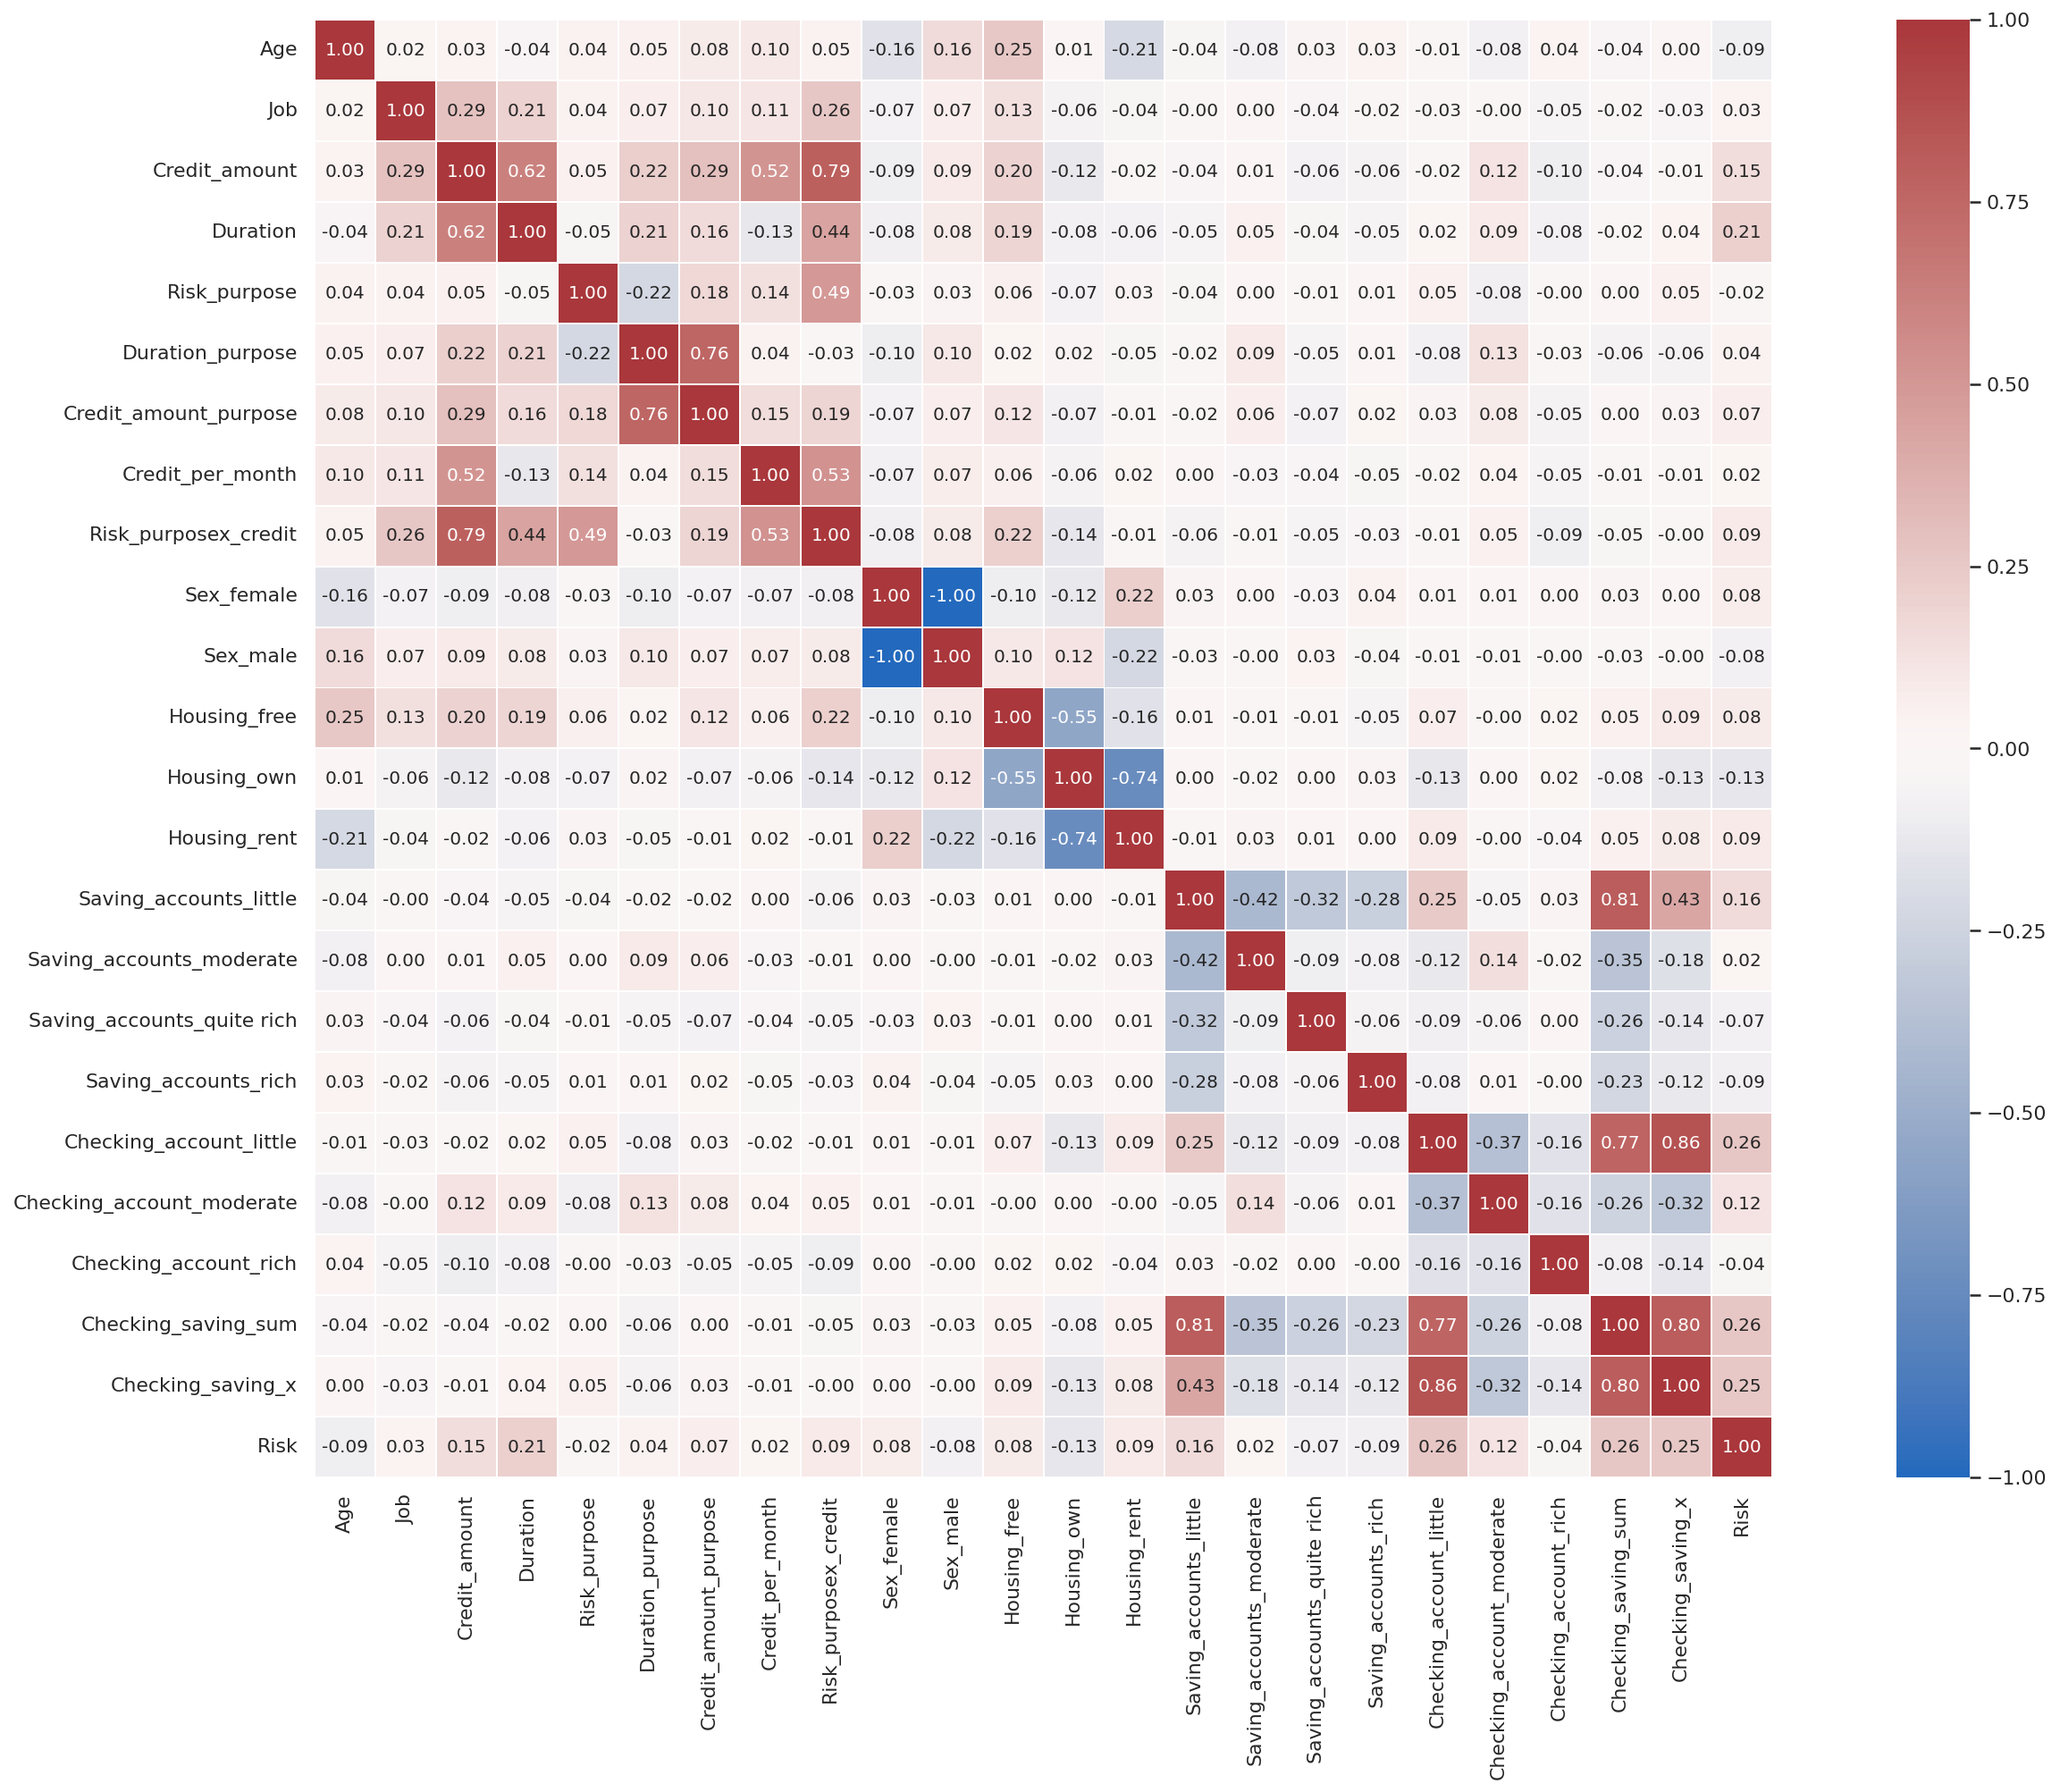

In [255]:
xy_std = pd.concat([X_std, y], axis=1)

heat = xy_std.corr()
# fmt = lambda x,pos: '{:.0%}'.format(x)
plt.figure(figsize=(25,15))
sns.heatmap(heat, cmap='vlag', square=True, linewidth=0.5, annot=True, annot_kws={'fontsize':'small'}, fmt='.2f');

##Droping High correlated variables

In [256]:
cor_matrix = X_std.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.9)]
print(); print(to_drop)
X_std = X_std.drop(columns=to_drop)
X_std.head()


['Sex_male']


,Age,Job,Credit_amount,Duration,Risk_purpose,Duration_purpose,Credit_amount_purpose,Credit_per_month,Risk_purposex_credit,Sex_female,...,Housing_rent,Saving_accounts_little,Saving_accounts_moderate,Saving_accounts_quite rich,Saving_accounts_rich,Checking_account_little,Checking_account_moderate,Checking_account_rich,Checking_saving_sum,Checking_saving_x
0,2.766456,0.146949,-0.745131,-1.236478,-0.214677,-0.345745,-0.946862,0.176948,-0.629841,-0.670280,...,-0.466933,-1.232433,-0.338862,-0.259299,-0.224544,1.627770,-0.606621,-0.259299,0.166479,-0.529537
1,-1.191404,0.146949,0.949817,2.248194,-0.214677,-0.345745,-0.946862,-0.284901,0.565838,1.491914,...,-0.466933,0.811403,-0.338862,-0.259299,-0.224544,-0.614337,1.648476,-0.259299,0.166479,-0.529537
2,1.183312,-1.383771,-0.416562,-0.738668,-1.498986,-0.494471,-0.473736,0.045495,-0.727719,-0.670280,...,-0.466933,0.811403,-0.338862,-0.259299,-0.224544,-0.614337,-0.606621,-0.259299,0.166479,-0.529537
3,0.831502,0.146949,1.634247,1.750384,-0.346401,-0.649932,-0.246827,0.130233,0.921512,-0.670280,...,-0.466933,0.811403,-0.338862,-0.259299,-0.224544,1.627770,-0.606621,-0.259299,1.519969,1.888441
4,1.535122,0.146949,0.566664,0.256953,1.234287,-0.036305,0.600467,0.229637,1.159709,-0.670280,...,-0.466933,0.811403,-0.338862,-0.259299,-0.224544,1.627770,-0.606621,-0.259299,1.519969,1.888441


#4 Modelagem

* Divisão treino/teste: 80/20

* Algoritmos: Naive Bayes, Regressão logística, Árvores de decisão, SVC.

* Métricas: Acurácia e ROC-AUC

##Segmentação das bases

In [257]:
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split

xS_train, xS_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=123)

##Naive Bayes

In [258]:
from sklearn.naive_bayes import GaussianNB

naive = GaussianNB().fit(xS_train, y_train)

y_naive = naive.predict(xS_test)

print(f"Acurácia: {accuracy_score(y_test, y_naive)}")
print(f"ROC AUC: {roc_auc_score(y_test,y_naive)}")

Acurácia: 0.685
ROC AUC: 0.6721901167590518


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


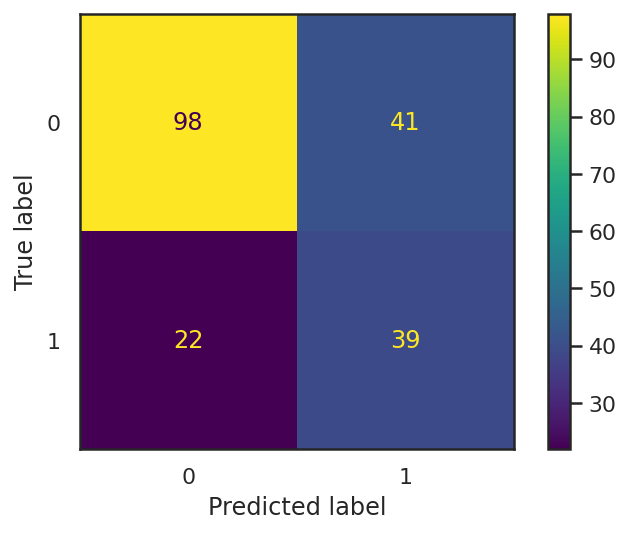

In [259]:
plot_confusion_matrix(naive, xS_test, y_test);

##Regressão Logística

In [260]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(solver="liblinear", random_state=0).fit(xS_train, y_train)

y_reg= reg.predict(xS_test)
print(f"Acurácia: {accuracy_score(y_test, y_reg)}")
print(f"ROC AUC: {roc_auc_score(y_test,y_reg)}")

Acurácia: 0.73
ROC AUC: 0.6493690293666706


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


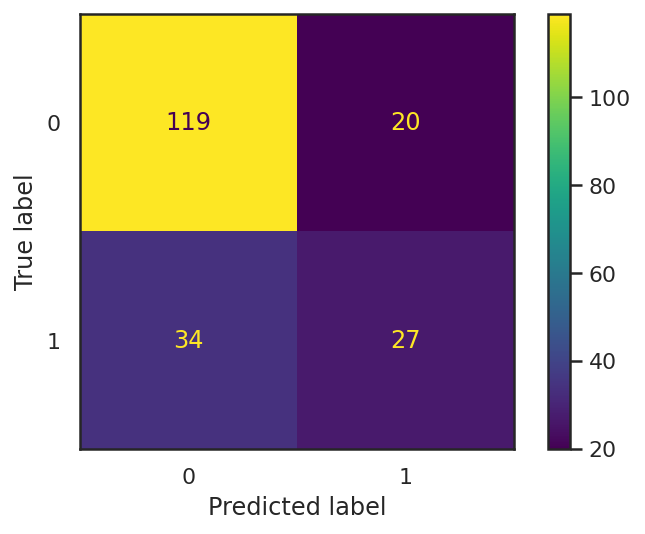

In [261]:
plot_confusion_matrix(reg, xS_test, y_test);

##Árvore de decisão

In [262]:
from sklearn.tree import DecisionTreeClassifier

treed = DecisionTreeClassifier(max_depth=5, min_samples_split=20, min_samples_leaf=5, random_state=0).fit(xS_train, y_train)
y_tree = treed.predict(xS_test)

print(f"Acurácia: {accuracy_score(y_test, y_tree)}")
print(f"ROC AUC: {roc_auc_score(y_test,y_tree)}")

Acurácia: 0.78
ROC AUC: 0.7221370444627904


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


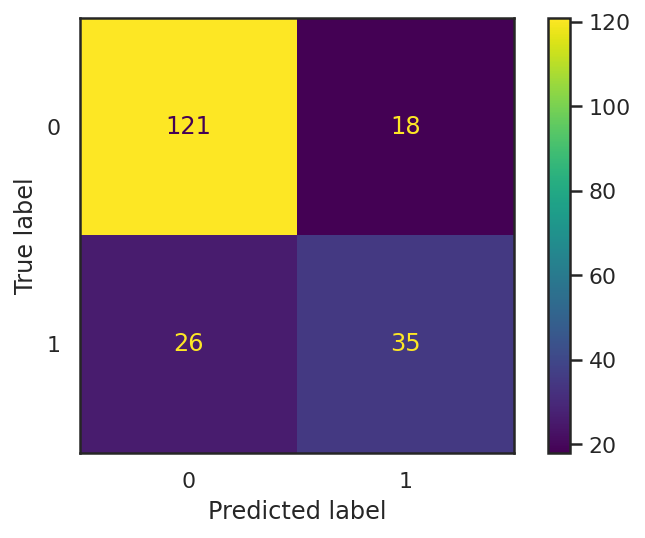

In [263]:
plot_confusion_matrix(treed, xS_test, y_test);

##SVC

In [264]:
from sklearn.svm import SVC

svc = SVC(gamma='auto').fit(xS_train, y_train)
y_svc = svc.predict(xS_test)

print(f"Acurácia: {accuracy_score(y_test, y_svc)}")
print(f"ROC AUC: {roc_auc_score(y_test,y_svc)}")

Acurácia: 0.755
ROC AUC: 0.6443566458308763


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


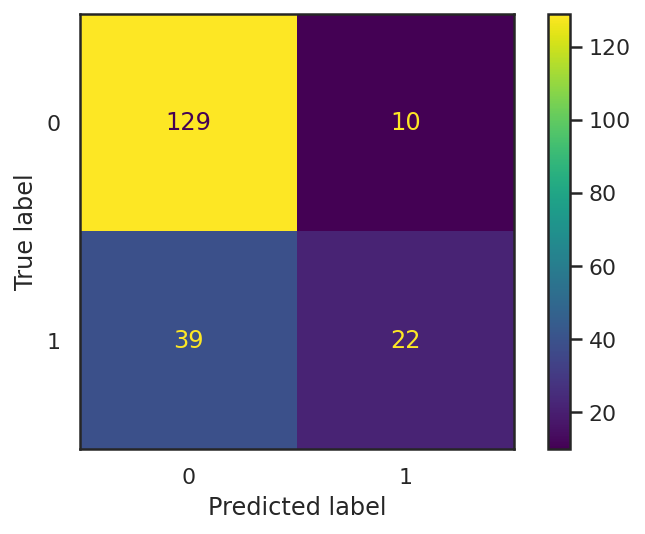

In [265]:
plot_confusion_matrix(svc, xS_test, y_test)

# 5. Evaluate

De acordo com as métricas o melhor modelo foi a **Árvore de decisão.**

A recomendação é que este modelo seja utilizado na análise de risco de crédito de futuros clientes e que ele seja constantemente avaliado e otimizado.